###### Dimensionality Reduction Starter Coder 
# Version 6 includes TFIDF Cosine Similarity Starter Code
# Doc2Vec and Word2Vec
# TSNE visualization and K-Means document listings are provided to help you perform analysis
## 2021WI_MSDS_453-DL_SEC56
### jennifer.sleeman@northwestern.edu, paulhuynh2018@u.northwestern.edu



In [105]:
pip install rake-nltk

In [106]:
pip install phrasemachine

In [107]:
###############################################################################
### packages required to run code.  Make sure to install all required packages.
###############################################################################
import re,string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize 
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import ngrams, FreqDist
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.manifold import MDS
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.manifold import TSNE

from gensim.models import Word2Vec,LdaMulticore, TfidfModel
from gensim import corpora
from gensim.models.doc2vec import Doc2Vec, TaggedDocument


import pandas as pd
import os
import numpy as np
import phrasemachine
from rake_nltk import Rake
import re
import matplotlib.pyplot as plt
from numpy import array
from numpy import argmax
import gensim




In [108]:
#################################################################################
#An Example of One-hot encoding  
#Very Simple Based on example in Deep Learning for Natural Language Processing
#################################################################################
# define example
data = ['ginsburg', 'RBG', 'justice', 'ginsburg']
values = np.array(data)
print(values)
# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
print(integer_encoded)
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded)
# invert first example
inverted = label_encoder.inverse_transform([np.argmax(onehot_encoded[0, :])])
print(inverted)

['ginsburg' 'RBG' 'justice' 'ginsburg']
[1 0 2 1]
[[0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]
['ginsburg']


In [109]:
# Only run this once, they will be downloaded.
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [110]:
# Create a list of stop words from nltk
stop_words = set(stopwords.words("english"))

In [111]:
# Pre-process dataset to remove punctuation
def remove_punctuation(in_text):
    # Remove punctuation
    text = re.sub('[^a-zA-Z]', ' ', str(in_text))
    return text

In [112]:
# Pre-process dataset to lower case it
def lower_case(in_text):
    # Convert to lowercase
    text = in_text.lower()    
    return text

In [113]:
# Pre-process dataset to remove tags
def remove_tags(in_text):    
    # Remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",in_text)
    return text

In [114]:
# Pre-process dataset to remove special characters and digits
def remove_special_chars_and_digits(in_text):
    # Remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",in_text)
    return text


In [115]:
# Pre-process dataset to appy Stemming
def apply_stemming(in_text):
    stemmer=PorterStemmer()
    word_list = nltk.word_tokenize(in_text)
    output = ' '.join([stemmer.stem(w) for w in word_list])
    return output

In [116]:
# Pre-process dataset to apply Lemmatization
def apply_lemmatization(in_text):
    # Lemmatization
    lem = WordNetLemmatizer()
    word_list = nltk.word_tokenize(in_text)
    output = ' '.join([lem.lemmatize(w) for w in word_list])
    return output

In [117]:
# Remove stop words
def remove_stop_words(in_text):
    stop_words = set(stopwords.words('english')) 
    word_tokens = word_tokenize(in_text)  
    filtered_sentence = [w for w in word_tokens if not w in stop_words] 
    filtered_sentence = [] 
    for w in word_tokens: 
        if w not in stop_words: 
            filtered_sentence.append(w) 

    return filtered_sentence

In [118]:
# Run Phase Machine
def run_phrase_machine(in_text):
    phrases=phrasemachine.get_phrases(in_text)
    return phrases

In [119]:
#Run Rake Keyword Extractor
def run_rake(in_text):
    r = Rake()
    r.extract_keywords_from_text(in_text)
    rake_phrases= r.get_ranked_phrases()
    return rake_phrases

In [120]:
# Run NLTK Tokenizer
def run_nltk_tokenizer(in_text):
    tokens=nltk.word_tokenize(in_text)
    return tokens

In [121]:
# Run NLTK Sentence Tokenizer
def run_nltk_sent_tokenizer(in_corpus):
    sents = nltk.sent_tokenize(in_corpus)
    return sents

In [122]:
#Run word-ngram Tokenizer
def run_nltk_tokenizer_word_ngrams(in_text, ngram_size):
    n_grams = ngrams(nltk.word_tokenize(in_text), ngram_size)
    return [ ' '.join(grams) for grams in n_grams]

In [123]:
#Get Frequ Dist 
def get_freq_dist(terms):
    all_counts = dict()
    all_counts[size] = FreqDist(terms)
    return all_counts

In [124]:

###############################################################################
### Processing text into lists
###############################################################################
def get_corpus(path_to_file):
    #read in class corpus csv into python
    data=pd.read_csv(path_to_file)

    #create empty list to store text documents titles
    titles=[]
    docids=[]
    #for loop which appends the DSI title to the titles list
    for i in range(0,len(data)):
        docids.append(data['Doc_ID'].iloc[i])

    #for loop which appends the DSI title to the titles list
    for i in range(0,len(data)):
        titles.append(data['DSI_Title'].iloc[i])

    #create empty list to store text documents
    text_body=[]

    #for loop which appends the text to the text_body list
    for i in range(0,len(data)):
        temp_text=data['Text'].iloc[i]
        text_body.append(temp_text)
    return (docids,titles,text_body)

In [140]:
stopwords = stopwords.words('english')
stopwords.extend(["alice", "carter", "external", "director", "michael", "baron", "george", "mr.", "amlie", "firstname","almost","another","seems","enough","might","never","doesnt","really","looks","theres","words","thats","though","place","article","character","characters","james","point","characters","feels","links","edward","little","could","would","finds","still","every","whose","eastwood","played","review","takes","makes","us","title","remake","jones","editor","around","comes","something","years","allens","allen","things"])
stopwords.extend(["'s", "n't", "ii", "'ll"])

In [141]:
###############################################################################
### Functions to visualize documents
###############################################################################
def clean_doc(doc): 
    #split document into individual words
    tokens=doc.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 4]
    #lowercase all words
    tokens = [word.lower() for word in tokens]
    # filter out stop words
    stop_words = set(stopwords)
    tokens = [w for w in tokens if not w in stop_words]
    # word stemming    
    #ps=PorterStemmer()
    #tokens=[ps.stem(word) for word in tokens]
  
    return tokens

def process_corpus(data):
        
    #create empty list to store text documents titles
    titles=[]
    
    #for loop which appends the DSI title to the titles list
    for i in range(0,len(data)):
        temp_text=data['DSI_Title'].iloc[i]
        titles.append(temp_text)
    
    #create empty list to store text documents
    text_body=[]
    
    #for loop which appends the text to the text_body list
    for i in range(0,len(data)):
        temp_text=data['Text'].iloc[i]
        text_body.append(temp_text)
    
    #Note: the text_body is the unprocessed list of documents read directly form 
    #the csv.
        
    #empty list to store processed documents
    processed_text=[]
    #for loop to process the text to the processed_text list
    for i in text_body:
        text=clean_doc(i)
        processed_text.append(text)
    
    #Note: the processed_text is the PROCESSED list of documents read directly form 
    #the csv.  Note the list of words is separated by commas.
    
    
    #stitch back together individual words to reform body of text
    final_processed_text=[]
    
    for i in processed_text:
        temp_DSI=i[0]
        for k in range(1,len(i)):
            temp_DSI=temp_DSI+' '+i[k]
        final_processed_text.append(temp_DSI)
    
    return titles, final_processed_text, processed_text

def run_doc2vec(final_processed_text, processed_text):
    #create doc2vec matrix
    documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(final_processed_text)]
    model = Doc2Vec(documents, vector_size=1000, window=2, min_count=1, workers=4)    
    doc2vec_df=pd.DataFrame()
    for i in range(0,len(processed_text)):
        vector=pd.DataFrame(model.infer_vector(processed_text[i])).transpose()
        doc2vec_df=pd.concat([doc2vec_df,vector], axis=0)
        
    return doc2vec_df

def run_word2vec(processed_text):

    #word to vec model
    model_w2v = Word2Vec(processed_text, size=100, window=5, min_count=1, workers=4)
    
    labels = []
    tokens = []

    for word in model_w2v.wv.vocab:
        tokens.append(model_w2v[word])
        labels.append(word)
    
    
    return labels, tokens, model_w2v





def plot_doc2vec(doc2vec_df, titles, perplexity = 2):
    #visualize documents through applying TSNE to doc2vec matrix
    tsne_model = TSNE(perplexity=2, n_components=2, init='pca', n_iter=2500, random_state=23)

    doc2vec_df = tsne_model.fit_transform(doc2vec_df)
    x = []
    y = []
    for value in doc2vec_df:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(titles[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

def plot_word2vec(model, labels, tokens):
    "Creates and TSNE model and plots it"
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(40, 40)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

In [127]:
!pip install pyLDAvis==2.1.2

In [128]:
###############################################################################
### packages required to run code.  Make sure to install all required packages.
###############################################################################
import re,string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold

import pandas as pd
import os

from gensim.models import Word2Vec,LdaMulticore, TfidfModel
from gensim import corpora
from gensim import similarities


from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim import corpora
from gensim.models import LsiModel,LdaModel
import seaborn as sns

import numpy as np
import pyLDAvis
import pyLDAvis.gensim
import pickle 

import warnings
warnings.filterwarnings('ignore')
# Visualize the topics
pyLDAvis.enable_notebook()

In [129]:
#Section 1: Latent Semantic Analysis Using Gensim's implementation
def create_gensim_lsa_model(doc_clean,number_of_topics,words):

    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    index = similarities.MatrixSimilarity(lsamodel[doc_term_matrix])

    return lsamodel,dictionary,index

In [130]:
#Section 1: Latent Semantic Analysis Example
def lsa(tfidf_matrix, n_components = 5):
    #this is a function to execute lsa.  inputs to the function include the tfidf matrix and
    #the desired number of components.
    
    LSA = TruncatedSVD(n_components=5)

    LSA.fit(tfidf_matrix)


    for i, comp in enumerate(LSA.components_):
        terms_comp = zip(terms, comp)
        sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
        print("Topic "+str(i)+": ")
        for t in sorted_terms:
            print(t[0])

In [131]:
#Section 2: Latent Dirichlet Allocation
def lda(tfidf_matrix, topics = 5, num_words = 10):
    #this is a function to perform lda on the tfidf matrix.  function varibales include:
    #tfidf matrix, desired number of topic, and number of words per topic.

    topics = 5
    num_words = 10
    lda = LatentDirichletAllocation(n_components=topics).fit(tfidf_matrix)

    topic_dict = {}
    for topic_num, topic in enumerate(lda.components_):
        topic_dict[topic_num] = " ".join([terms[i]for i in topic.argsort()[:-num_words - 1:-1]])

    print(topic_dict)

In [132]:
#Section 3: Word2Vec Matrix Generation
def word2vec(processed_text, size = 100):
    #This is a function to generate the word2vec matrix. Input parameters include the 
    #tokenized text and matrix size
    
    #word to vec
    model_w2v = Word2Vec(processed_text, size=100, window=5, min_count=1, workers=4)

    #join all processed DSI words into single list
    processed_text_w2v=[]
    for i in processed_text:
        for k in i:
            processed_text_w2v.append(k)

    #obtian all the unique words from DSI
    w2v_words=list(set(processed_text_w2v))

    #can also use the get_feature_names() from TFIDF to get the list of words
    #w2v_words=Tfidf.get_feature_names()

    #empty dictionary to store words with vectors
    w2v_vectors={}

    #for loop to obtain weights for each word
    for i in w2v_words:
        temp_vec=model_w2v.wv[i]
        w2v_vectors[i]=temp_vec

    #create a final dataframe to view word vectors
    w2v_df=pd.DataFrame(w2v_vectors).transpose()
    print(w2v_df)
    return w2v_df

In [133]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [134]:
###############################################################################
### Setup path to file, get the corpus, set up 
###############################################################################
path_to_file=('/content/drive/MyDrive/movie_reviews/2021_Winter_453_Sec56_Class_Corpus_Updated.csv')
docids,titles,text=get_corpus(path_to_file)
print(titles)

['KS_Doc1_2001 Space Odyssey.txt', 'KS_Doc2_Wargames.txt', 'KS_Doc3_The_Matrix.txt', 'KS_Doc4_I_Robot.txt', 'KS_Doc5_Ex_Machina.txt', 'KS_Doc6_Her.txt', 'KS_Doc7_The Terminator.txt', 'PP_Doc1_Disneys_New_Mulan.txt', 'PP_Doc2_Cinderella_Review_Straight-Faced.txt', 'PP_Doc3_Aladdin_Review_This.txt', 'PP_Doc4_Review_Beauty_And.txt', 'PP_Doc5_Film_Review_Tim.txt', 'PP_Doc6_The_Jungle_Book.txt', 'PP_Doc7_Whats_A_Nice.txt', 'SW_DOC1_AIRFORCEONE.txt', 'SW_DOC2_CLEARANDPRESENTDANGER.txt', 'SW_DOC3_CRIMSONTIDE.txt', 'SW_DOC4_HUNTFORREDOCTOBER.txt', 'SW_DOC5_INTHELINEOFFIRE.txt', 'SW_DOC6_PATRIOTGAMES.txt', 'SW_DOC7_FUGITIVE.txt', 'VPD_DOC1_AMELIE.txt', 'VPD_DOC2_EAT_PRAY_LOVE.txt', 'VPD_DOC3_MIDNIGHT_IN_PARIS.txt', 'VPD_DOC4_THE_BEST_EXOTIC_MARIGOLD_HOTEL.txt', 'VPD_DOC5_THE_SECRET_LIFE_OF_WALTER_MITTY.txt', 'VPD_DOC6_THE_BUCKET_LIST.txt', 'VPD_DOC7_TO_ROME_WITH_LOVE.txt', 'YF_Doc1_Hidden_Figures.txt', 'YF_Doc2_The_Imitation_Game.txt', 'YF_Doc3_Argo.txt', 'YF_Doc4_Snowden.txt', 'YF_Doc5_The_Rev

In [135]:
from nltk.corpus import brown, stopwords
from nltk.cluster.util import cosine_distance
 
def sentence_similarity(sent1, sent2, stopwords=None):
    if stopwords is None:
        stopwords = []
 
    sent1 = [w.lower() for w in sent1]
    sent2 = [w.lower() for w in sent2]
 
    all_words = list(set(sent1 + sent2))
 
    vector1 = [0] * len(all_words)
    vector2 = [0] * len(all_words)
 
    # build the vector for the first sentence
    for w in sent1:
        if w in stopwords:
            continue
        vector1[all_words.index(w)] += 1
 
    # build the vector for the second sentence
    for w in sent2:
        if w in stopwords:
            continue
        vector2[all_words.index(w)] += 1
 
    return 1 - cosine_distance(vector1, vector2)

In [136]:
print(sentence_similarity("This is a good sentence".split(), "This is a bad sentence".split(), stopwords.words('english')))

0.4999999999999999


In [137]:
###############################################################################
### Calculates TFIDF and Saves TFIDF values for terms to a file
###############################################################################
vectorizer = TfidfVectorizer(stop_words='english', use_idf=True, norm=None)
transformed_documents = vectorizer.fit_transform(text)
transformed_documents_as_array = transformed_documents.toarray()

#CHANGE THIS PATH TO YOUR OWN
output_filenames ="tf_idf_output"

for counter, doc in enumerate(transformed_documents_as_array):
    # construct a dataframe
    tf_idf_tuples = list(zip(vectorizer.get_feature_names(), doc))
    one_doc_as_df = pd.DataFrame.from_records(tf_idf_tuples, columns=['term', 'score']).sort_values(by='score', ascending=False).reset_index(drop=True)

    # output to a csv using the enumerated value for the filename
    one_doc_as_df.to_csv(output_filenames+"_"+str(titles[counter]))

In [138]:
###############################################################################
### Calculates the Cosine Similarity across your corpus
###############################################################################
doc_term_matrix = transformed_documents.todense()
df = pd.DataFrame(doc_term_matrix, 
                      columns=vectorizer.get_feature_names(), 
                      index=docids)
   
print(cosine_similarity(df, df))

[[1.         0.05422149 0.03800689 ... 0.04551833 0.0227094  0.00924681]
 [0.05422149 1.         0.04107573 ... 0.03725507 0.02278297 0.00968259]
 [0.03800689 0.04107573 1.         ... 0.02627188 0.02624978 0.01969245]
 ...
 [0.04551833 0.03725507 0.02627188 ... 1.         0.18221265 0.14105931]
 [0.0227094  0.02278297 0.02624978 ... 0.18221265 1.         0.28621993]
 [0.00924681 0.00968259 0.01969245 ... 0.14105931 0.28621993 1.        ]]


In [142]:
#load class corpus
data=pd.read_csv(('/content/drive/MyDrive/movie_reviews/2021_Winter_453_Sec56_Class_Corpus_Updated.csv'))

#adding two columns to the dataframe to store the processed text and tokenized text
data['processed_text'] = data['Text'].apply(lambda x: clean_doc(x))



#creating final processed text variables for matrix creation
final_processed_text = [' '.join(x) for x in data['processed_text'].tolist()]
titles = data['DSI_Title'].tolist()
processed_text = data['processed_text'].tolist()

Let’s form the bigram and trigrams using the Phrases model. This is passed to Phraser() for efficiency in speed of execution.

Next, lemmatize each word to its root form, keeping only nouns, adjectives, verbs and adverbs.

We keep only these POS tags because they are the ones contributing the most to the meaning of the sentences. Here, I use spacy for lemmatization.

In [143]:
from gensim.utils import lemmatize, simple_preprocess
from gensim.models.phrases import Phrases,Phraser
import spacy

# Build the bigram and trigram models
data_words = final_processed_text
bigram = Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = Phrases(bigram[data_words], threshold=100)  
bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stopwords, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

final_processed_text = process_words(data_words)  # processed Text Data!

In [144]:
# =============================================================================
# Running functions to (1): process documents, (2) create doc2vec matrix, and
# (3)plotting with TSNE
# =============================================================================
#process documents
titles, final_processed_text, processed_text = process_corpus(data)

doc2vec_df = run_doc2vec(final_processed_text, processed_text)

labels, tokens, word2vec_model = run_word2vec(processed_text)

In [145]:
def save_list(lines, filename):
# convert lines to a single blob of text
  data = ','.join(map(str, lines))
# open file
  file = open(filename, 'w')
# write text
  file.write(data)
# close file
  file.close()

save_list(processed_text, 'keywords.txt')
save_list(text, 'rawtext.txt')

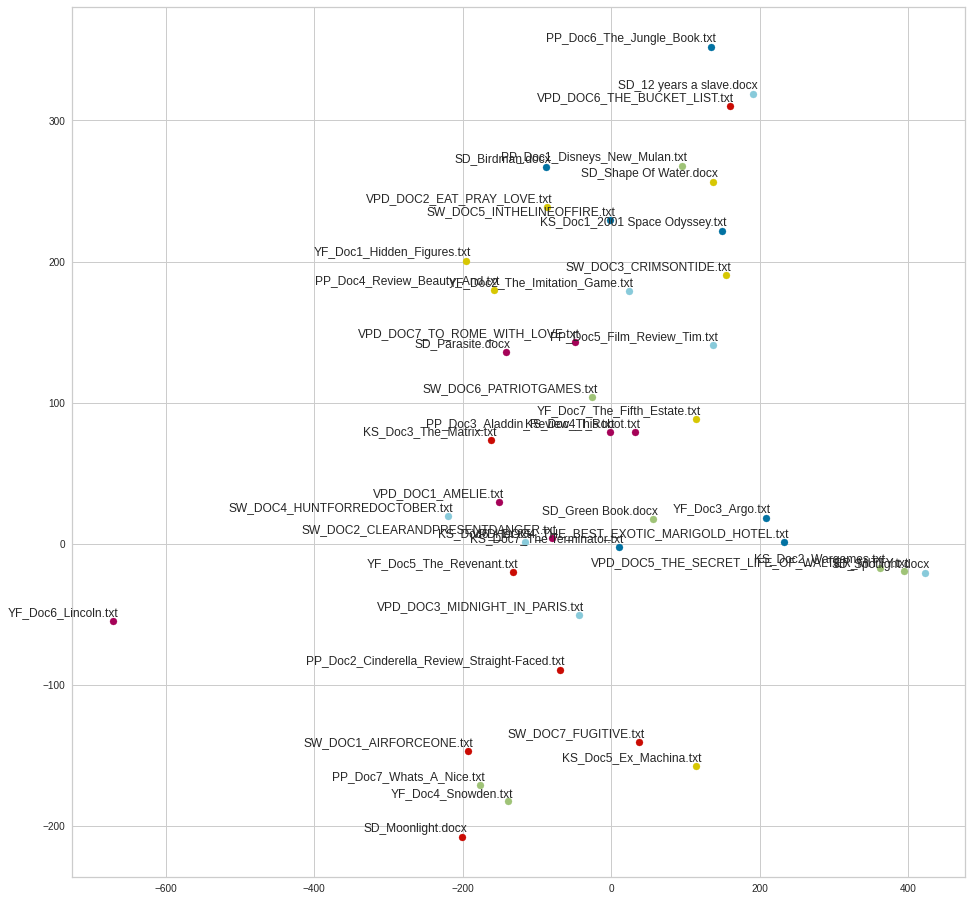

In [146]:
#plot doc2vec via TSNE
plot_doc2vec(doc2vec_df, titles)

In [147]:
#plot word2vec via TSNE
plot_word2vec(word2vec_model, labels, tokens)

Output hidden; open in https://colab.research.google.com to view.

In [148]:
from nltk import word_tokenize
from nltk.classify import NaiveBayesClassifier
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import extract_unigram_feats, mark_negation

In [149]:
import nltk.sentiment.util as nst

In [150]:
print (nst.mark_negation("I like the movie .".split()))       # ['I', 'like', 'the', 'movie.']
print (nst.mark_negation("I don't like the movie .".split()))  # ['I', "don't", 'like_NEG', 'the_NEG', 'movie._NEG']

['I', 'like', 'the', 'movie', '.']
['I', "don't", 'like_NEG', 'the_NEG', 'movie_NEG', '.']


In [151]:
analyzer = SentimentAnalyzer()
vocabulary = analyzer.all_words([nst.mark_negation(processed_text)])
print ("Vocabulary: ", len(vocabulary)) # 42

Vocabulary:  42


In [152]:
#############################################
#Explore K-means clustering of tfidf matrix
#############################################

#############################################
#Calculates tf idf
#Edit ngram range if you like
#############################################
def tfidf(corpus, titles, ngram_range = (1,1)):
    #this is a function to created the tfidf matrix
    Tfidf=TfidfVectorizer(ngram_range=(1,1))

    #fit the vectorizer using final processed documents.  The vectorizer requires the 
    #stiched back together document.

    TFIDF_matrix=Tfidf.fit_transform(corpus)     

    #creating datafram from TFIDF Matrix
    words = Tfidf.get_feature_names()
    matrix=pd.DataFrame(TFIDF_matrix.toarray(), columns=Tfidf.get_feature_names(), index=titles)
    return matrix, words

#############################################
#Performs the k-means clustering of the tfidf matrix
#Edit the number of clusters
#############################################
def k_means_tfidf(tfidf_matrix,terms,titles,final_processed_text, k=5):
    
    #this is a function to generate the k-means output using the tfidf matrix.  Inputs 
    #to the function include: titles of text, processed text, and desired k value. 
    km = KMeans(n_clusters=k, random_state =89)
    km.fit(tfidf_matrix)
    clusters = km.labels_.tolist()

    Dictionary={'Doc Name':titles, 'Cluster':clusters,  'Text': final_processed_text}
    frame=pd.DataFrame(Dictionary, columns=['Cluster', 'Doc Name','Text'])

    print("Top terms per cluster:")
    #sort cluster centers by proximity to centroid
    order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

    terms_dict=[]


    #save the terms for each cluster and document to dictionaries.  To be used later
    #for plotting output.

    #dictionary to store terms and titles
    cluster_terms={}
    cluster_title={}


    for i in range(k):
        print("Cluster %d:" % i),
        temp_terms=[]
        temp_titles=[]
        for ind in order_centroids[i, :50]:
            print(' %s' % terms[ind])
            terms_dict.append(terms[ind])
            temp_terms.append(terms[ind])
        cluster_terms[i]=temp_terms

        print("Cluster %d titles:" % i, end='')
        temp=frame[frame['Cluster']==i]
        for title in temp['Doc Name']:
            print(' %s,' % title, end='')
            temp_titles.append(title)
        cluster_title[i]=temp_titles
        

#############################################
# Run the code
#############################################
tfidf_matrix, terms = tfidf(final_processed_text, titles)
k_means_tfidf(tfidf_matrix,terms,titles,final_processed_text, k=5)

Top terms per cluster:
Cluster 0:
 computer
 robot
 india
 movie
 robots
 human
 intelligence
 space
 matrix
 turing
 spooner
 script
 voice
 future
 schwarzenegger
 water
 enigma
 extremely
 reeves
 terminator
 viewer
 shape
 computers
 especially
 scifi
 artificial
 asimov
 world
 programs
 named
 first
 cameron
 universe
 samanthas
 samantha
 theos
 elisa
 monster
 width
 effort
 certain
 bletchley
 system
 effect
 caleb
 genre
 morpheus
 wachowski
 story
 connects
Cluster 0 titles: KS_Doc1_2001 Space Odyssey.txt, KS_Doc2_Wargames.txt, KS_Doc3_The_Matrix.txt, KS_Doc4_I_Robot.txt, KS_Doc5_Ex_Machina.txt, KS_Doc6_Her.txt, KS_Doc7_The Terminator.txt, VPD_DOC4_THE_BEST_EXOTIC_MARIGOLD_HOTEL.txt, YF_Doc2_The_Imitation_Game.txt, SD_Shape Of Water.docx,Cluster 1:
 stone
 chiron
 three
 white
 themes
 slave
 familiar
 history
 story
 assange
 daniel
 filmmaking
 quiet
 movie
 racial
 scene
 young
 questions
 american
 better
 slavery
 black
 states
 united
 movies
 wikileaks
 presented
 nea

Single Value Decomposition

In [182]:
#create tfidf matrix and doc2vec matrix
tfidf_matrix, terms = tfidf(final_processed_text, titles)

#run section 3
word2vec(processed_text, size = 100)

from scipy import linalg
from scipy.linalg import svd
U, S, Vt = svd(tfidf_matrix)

svd = TruncatedSVD(n_components=5)
transformed = svd.fit_transform(tfidf_matrix)

print("Singular values:")
print(svd.singular_values_)

print("Transformed Matrix after reducing to 6 features:")
print(transformed)

for i, comp in enumerate(svd.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:15]
    print("Topic "+str(i)+": ")
    for t in sorted_terms:
        print(t[0])

                     0         1         2   ...        97        98        99
scoot          0.000694  0.004934  0.004091  ... -0.002191 -0.001404  0.002741
cubicle        0.003984 -0.000087 -0.004784  ... -0.001395  0.003412 -0.004239
primates       0.004689 -0.003378  0.004393  ... -0.002815  0.000177  0.003193
globetrotting  0.003093 -0.005001 -0.000177  ...  0.003434 -0.003790 -0.000404
drive         -0.001152  0.003322  0.001162  ... -0.004277  0.001438 -0.003654
...                 ...       ...       ...  ...       ...       ...       ...
monastic      -0.001997  0.000031 -0.004706  ... -0.001964  0.003415 -0.000858
fight         -0.004257 -0.000931 -0.004851  ...  0.002687 -0.003077 -0.001137
institutions   0.002240  0.000110  0.001213  ... -0.002779  0.002059  0.001515
rarely         0.002978 -0.003673 -0.003262  ... -0.003549 -0.004626 -0.000543
abandoned     -0.002391  0.003769  0.002982  ... -0.003721 -0.003326  0.001940

[4929 rows x 100 columns]
Singular values:
[1.42715

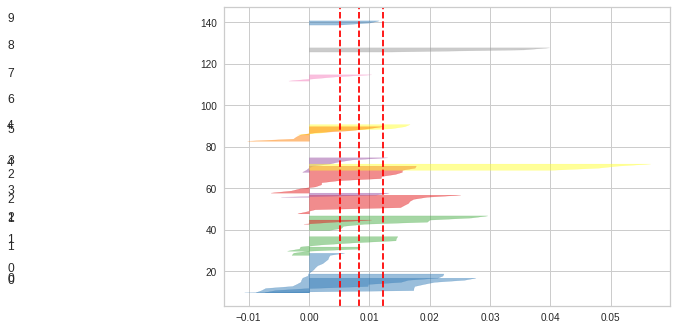

In [155]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer

# Number of clusters
num_clusters = (3,5,10)

for num in num_clusters:
    kmeans = KMeans(n_clusters=num)

    model_km = SilhouetteVisualizer(kmeans, colors='yellowbrick')
    model_km.fit(tfidf_matrix) # Fit the data to the visualizer
    model_km.fit_transform(tfidf_matrix, y=None, sample_weight=None)

From the silhouette plot above, we can see the average silhouette coefficients are similar among different solutions. There is no significant preference over one solution. As we know our dataset contains movie reviews, the movies probably would fall into five movie genres: science ficiton, comedy & drama, fantasy & adventure, action & thriller, romance & drama. So I decide to use 5 as the number of clusters in the kmeans.

[(0, '0.485*"movie" + 0.190*"story" + 0.158*"disney" + 0.146*"first" + 0.117*"computer" + 0.116*"movies" + 0.109*"washington" + 0.107*"october" + 0.103*"human" + 0.101*"captain"'), (1, '0.323*"captain" + 0.318*"october" + 0.283*"washington" + -0.194*"disney" + 0.158*"states" + 0.158*"united" + 0.136*"soviet" + 0.130*"hackman" + -0.112*"story" + 0.110*"submarine"'), (2, '-0.511*"spotlight" + -0.298*"boston" + -0.213*"church" + -0.202*"story" + -0.173*"globe" + -0.172*"abuse" + 0.140*"disney" + 0.130*"movie" + -0.120*"stories" + -0.100*"first"'), (3, '-0.326*"robot" + 0.274*"disney" + -0.203*"robots" + -0.173*"human" + -0.170*"spooner" + 0.145*"jungle" + 0.131*"original" + 0.119*"mowgli" + -0.115*"computer" + -0.113*"asimov"'), (4, '0.247*"captain" + 0.247*"robot" + -0.190*"president" + -0.168*"force" + 0.164*"october" + 0.159*"human" + 0.148*"robots" + -0.140*"presidential" + 0.132*"spooner" + 0.121*"disney"')]


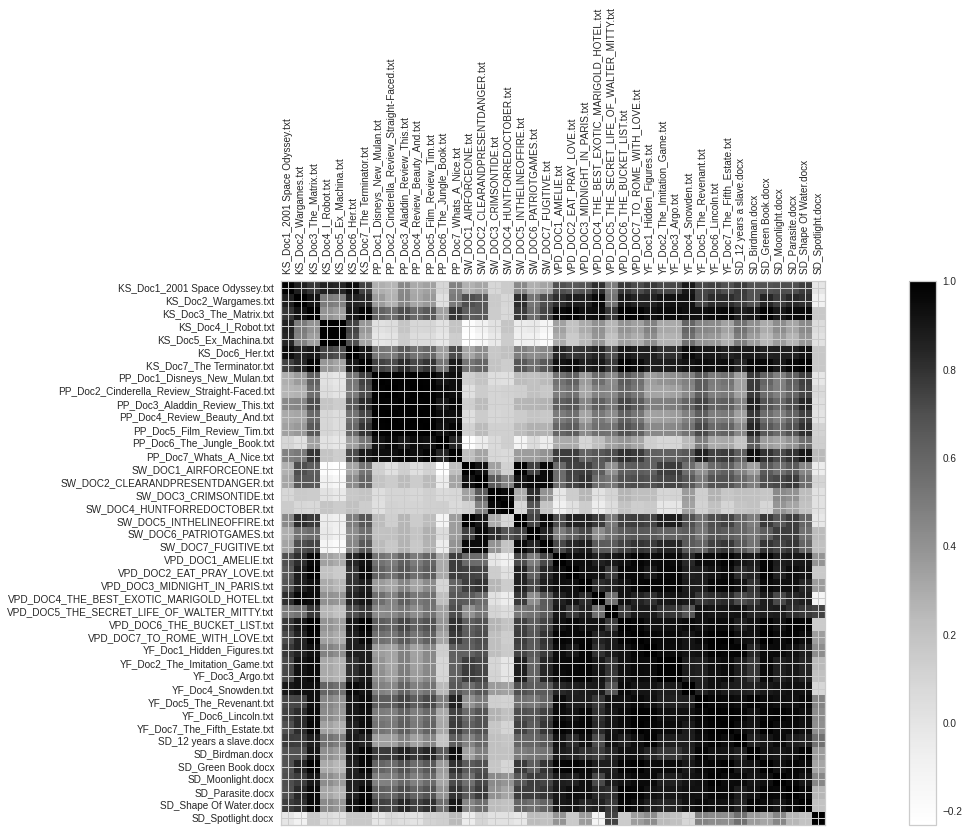

In [156]:
#run section 1
######################################
#EXPERIMENT WITH THESE PARAMETERS
number_of_topics=5
words=10
#####################################

model,dictionary,index=create_gensim_lsa_model( processed_text,number_of_topics,words)

for doc in processed_text:
    vec_bow = dictionary.doc2bow(doc)
    vec_lsi = model[vec_bow]  # convert the query to LSI space
    sims = index[vec_lsi] # perform a similarity query against the corpus

fig, ax = plt.subplots(figsize=(30, 10))
cax = ax.matshow(index, interpolation='nearest')
ax.grid(True)
plt.xticks(range(len(processed_text)), titles, rotation=90);
plt.yticks(range(len(processed_text)), titles);
fig.colorbar(cax)
plt.show()

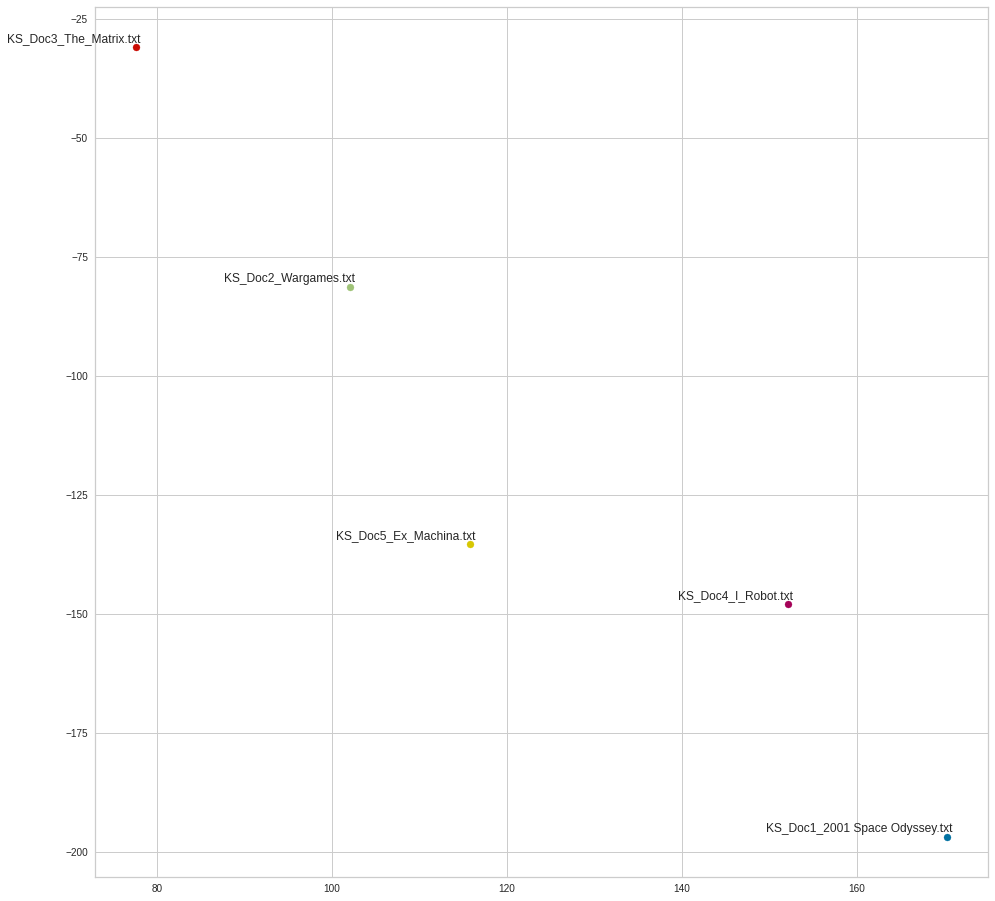

In [157]:
plot_doc2vec(vec_lsi, titles)

In [158]:
#Section 2:  Latent Dirichlet Allocation Using Gensim's implementation
def create_gensim_lda_model(doc_clean,number_of_topics,words):

    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LSA model
    ldamodel = LdaModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)
    # train model
    print(ldamodel.print_topics(num_topics=number_of_topics, num_words=words))
    index = similarities.MatrixSimilarity(ldamodel[doc_term_matrix])



    return ldamodel,dictionary,index,doc_term_matrix

In [159]:
from gensim.models.coherencemodel import CoherenceModel
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LDA model
        model = LdaModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary,chunksize=100, alpha='auto', eta='auto', iterations=500, passes=20, eval_every=1)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [160]:
def plot_graph(doc_clean,start, stop, step):
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

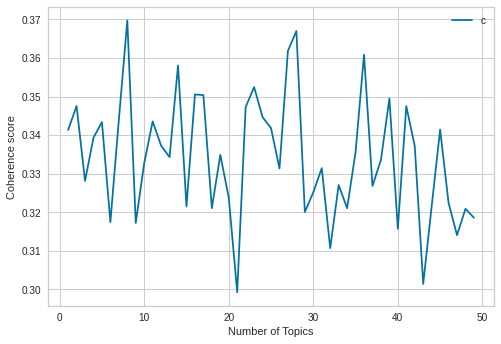

In [161]:
plot_graph(processed_text,1,50,1)

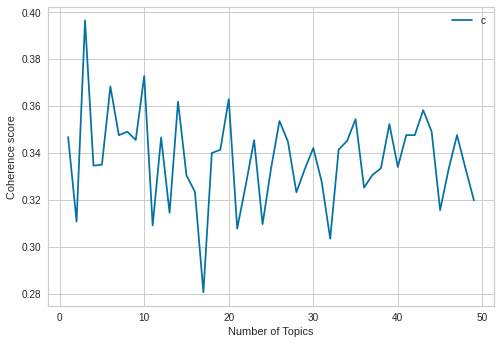

In [162]:
plot_graph(processed_text,1,50,1)

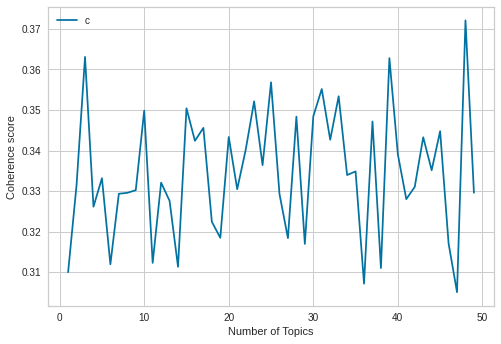

In [163]:
plot_graph(processed_text,1,50,1)

In [164]:
#run section 2
# Compare this implementation of lda with the gensim
# Any differences in behavior?
number_of_topics=5
words=10

lda(tfidf_matrix, topics = number_of_topics, num_words = 10)

{0: 'movie computer spotlight india story force robot president disney presidential', 1: 'mulan cinderella turing disney movie intelligence present cancer bucket clear', 2: 'captain october paris dumbo washington hackman schwarzenegger slave soviet submarine', 3: 'chiron fugitive gerard train single filmmaking episode execution themes three', 4: 'jungle stone mowgli family disney inarritu movie friend tutor story'}


In [165]:
#run section 3
word2vec_run=word2vec(processed_text, size = 100)

                     0         1         2   ...        97        98        99
scoot          0.000694  0.004934  0.004091  ... -0.002191 -0.001404  0.002741
cubicle        0.003984 -0.000087 -0.004784  ... -0.001395  0.003412 -0.004239
primates       0.004689 -0.003378  0.004393  ... -0.002815  0.000177  0.003193
globetrotting  0.003093 -0.005001 -0.000177  ...  0.003434 -0.003790 -0.000404
drive         -0.001152  0.003322  0.001162  ... -0.004277  0.001438 -0.003654
...                 ...       ...       ...  ...       ...       ...       ...
monastic      -0.001997  0.000031 -0.004706  ... -0.001964  0.003415 -0.000858
fight         -0.004257 -0.000931 -0.004851  ...  0.002687 -0.003077 -0.001137
institutions   0.002240  0.000110  0.001213  ... -0.002779  0.002059  0.001515
rarely         0.002978 -0.003673 -0.003262  ... -0.003549 -0.004626 -0.000543
abandoned     -0.002391  0.003769  0.002982  ... -0.003721 -0.003326  0.001940

[4929 rows x 100 columns]


[(0, '0.006*"movie" + 0.003*"story" + 0.003*"disney" + 0.003*"movies" + 0.002*"robot" + 0.002*"first" + 0.002*"human" + 0.002*"india" + 0.002*"washington" + 0.002*"mulan"'), (1, '0.008*"movie" + 0.004*"computer" + 0.003*"story" + 0.002*"first" + 0.002*"disney" + 0.002*"spotlight" + 0.002*"paris" + 0.002*"world" + 0.002*"human" + 0.002*"young"'), (2, '0.005*"movie" + 0.002*"disney" + 0.002*"story" + 0.002*"first" + 0.002*"movies" + 0.001*"recent" + 0.001*"young" + 0.001*"familiar" + 0.001*"world" + 0.001*"white"'), (3, '0.007*"movie" + 0.003*"story" + 0.002*"washington" + 0.002*"first" + 0.002*"world" + 0.002*"hackman" + 0.002*"october" + 0.002*"young" + 0.002*"captain" + 0.001*"united"'), (4, '0.008*"movie" + 0.003*"first" + 0.002*"story" + 0.002*"disney" + 0.002*"movies" + 0.002*"world" + 0.002*"washington" + 0.001*"force" + 0.001*"president" + 0.001*"human"')]


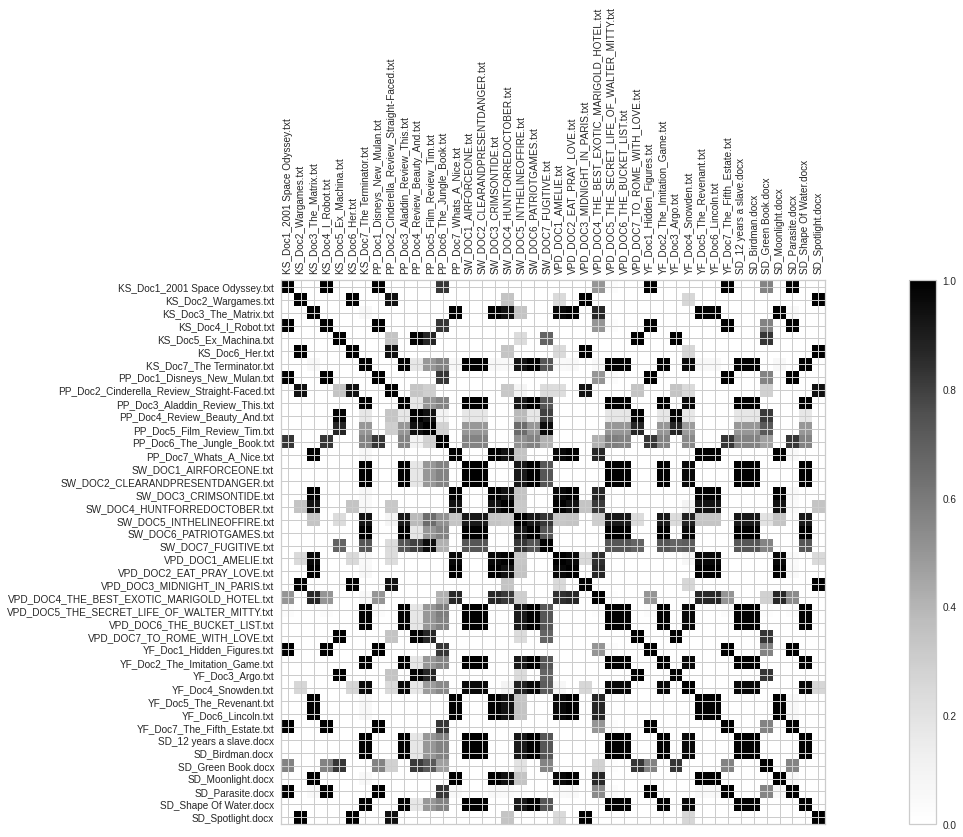

In [166]:
#run section 2
######################################
#EXPERIMENT WITH THESE PARAMETERS
number_of_topics=5
words=10
#####################################
model2,dictionary2,index2,doctermmatrix2=create_gensim_lda_model( processed_text,number_of_topics,words)

for doc in processed_text:
    vec_bow2 = dictionary2.doc2bow(doc)
    vec2 = model2[vec_bow2]  # convert the query to embedded space
    sims2 = index2[vec2]  # perform a similarity query against the corpus
    #print(list(enumerate(sims2)))  

fig, ax = plt.subplots(figsize=(30, 10))
cax = ax.matshow(index2, interpolation='nearest')
ax.grid(True)
plt.xticks(range(len(processed_text)), titles, rotation=90);
plt.yticks(range(len(processed_text)), titles);
fig.colorbar(cax)
plt.show()

[(0, '0.004*"movie" + 0.003*"story" + 0.002*"world" + 0.002*"movies" + 0.001*"disney" + 0.001*"white" + 0.001*"script" + 0.001*"first" + 0.001*"washington" + 0.001*"thing"'), (1, '0.006*"movie" + 0.003*"first" + 0.002*"spotlight" + 0.002*"story" + 0.002*"computer" + 0.002*"world" + 0.002*"young" + 0.002*"india" + 0.001*"boston" + 0.001*"space"'), (2, '0.005*"movie" + 0.003*"first" + 0.002*"disney" + 0.002*"story" + 0.002*"president" + 0.002*"movies" + 0.002*"young" + 0.002*"films" + 0.001*"world" + 0.001*"familiar"'), (3, '0.011*"movie" + 0.003*"disney" + 0.003*"story" + 0.003*"computer" + 0.003*"washington" + 0.002*"first" + 0.002*"movies" + 0.002*"captain" + 0.002*"human" + 0.002*"mulan"'), (4, '0.006*"movie" + 0.003*"story" + 0.003*"first" + 0.002*"movies" + 0.002*"human" + 0.002*"paris" + 0.002*"disney" + 0.002*"robot" + 0.002*"world" + 0.001*"white"')]


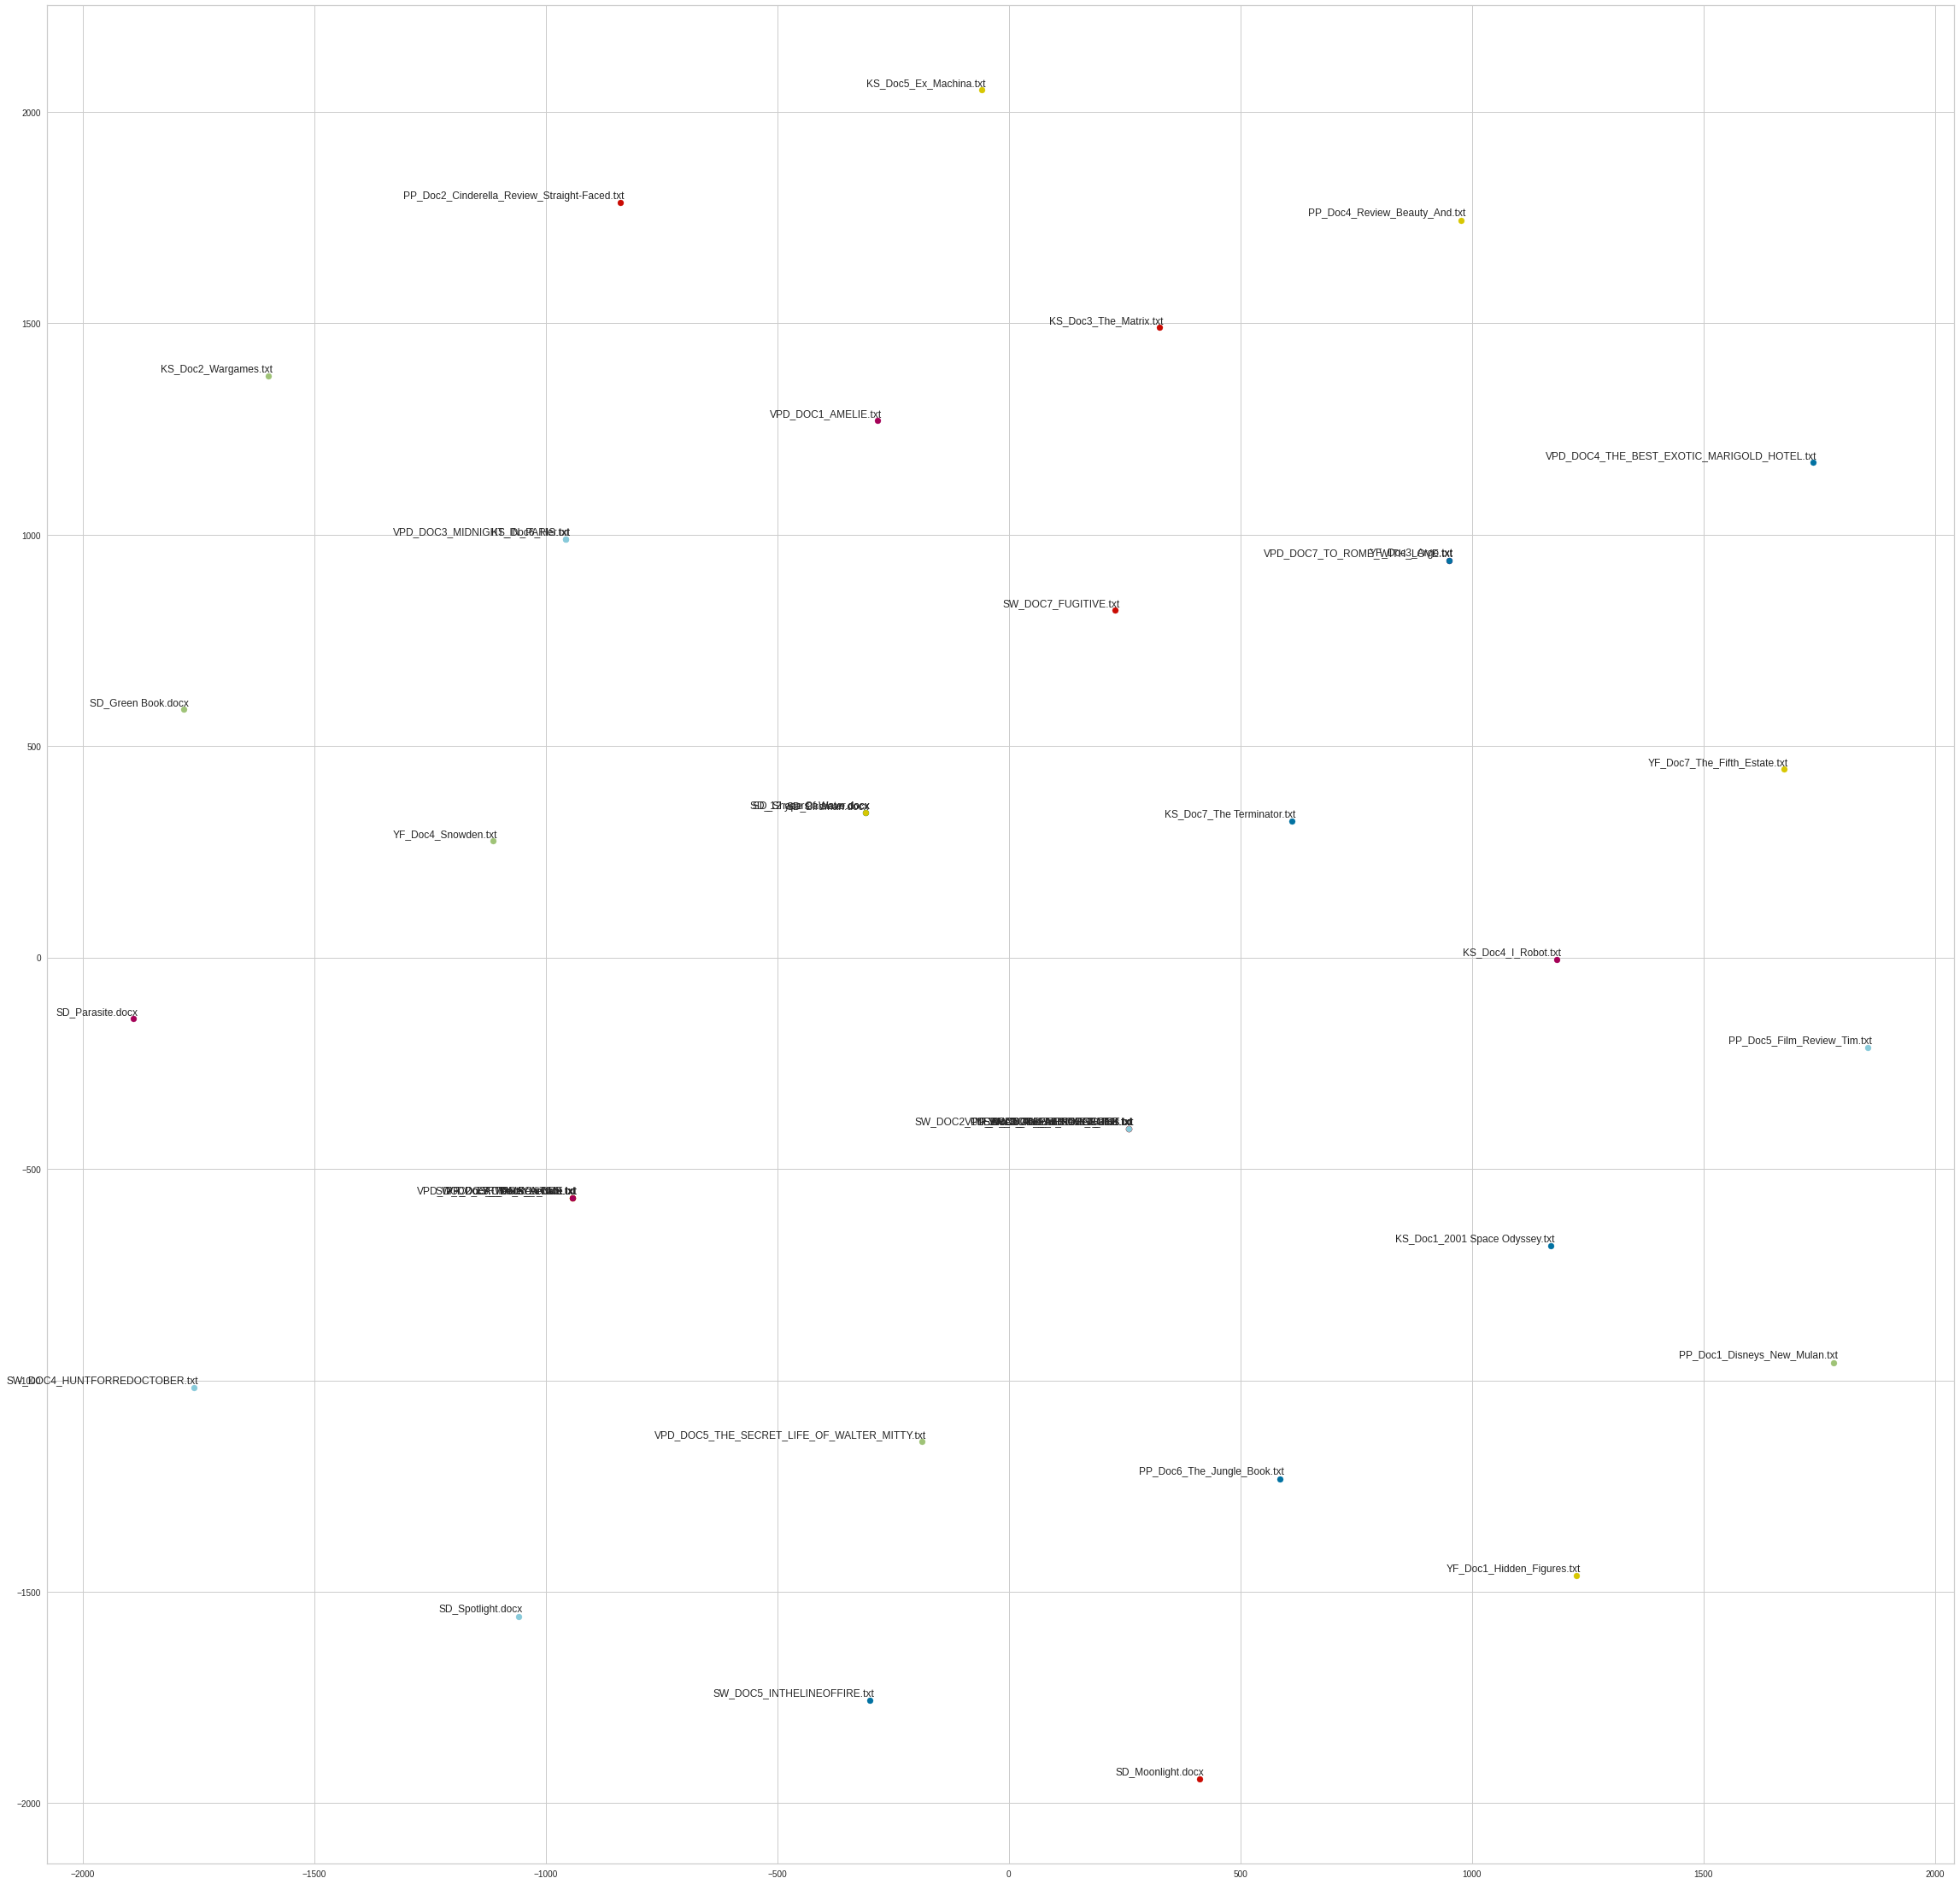

In [167]:
#plot LDA model via TSNE
lda_model=create_gensim_lda_model( processed_text,number_of_topics,words)
plot_word2vec(lda_model,titles, index2)

In [168]:
LDAvis_prepared = pyLDAvis.gensim.prepare(model2, doctermmatrix2, dictionary2)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.001943  0.010342       1        1  33.836728
3      0.019060 -0.006124       2        1  21.098308
0      0.001364  0.005836       3        1  17.084433
2     -0.012581  0.003476       4        1  15.299317
1     -0.009786 -0.013530       5        1  12.681213, topic_info=           Term       Freq      Total Category  logprob  loglift
29     computer  11.000000  11.000000  Default  30.0000  30.0000
93        movie  58.000000  58.000000  Default  29.0000  29.0000
119       robot   8.000000   8.000000  Default  28.0000  28.0000
4920  spotlight   7.000000   7.000000  Default  27.0000  27.0000
1143      mulan   5.000000   5.000000  Default  26.0000  26.0000
...         ...        ...        ...      ...      ...      ...
1158      scene   1.061767   8.299191   Topic5  -6.9322   0.0088
1470      times   1.015456   7.236607   Topic5  -6.9768   0.1012
221       films   1.029340   8.752113   Topic5  -6.9632  -0.0753
2200    october   1.050325  10.393482   Topic5  -6.9430  -0.2270
2100     united   0.991305   8.389338   Topic5  -7.0009  -0.0706

[382 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
307       1  0.378756  action
307       2  0.126252  action
307       3  0.126252  action
307       4  0.126252  action
307       5  0.126252  action
...     ...       ...     ...
764       1  0.184721   young
764       2  0.277081   young
764       3  0.184721   young
764       4  0.184721   young
764       5  0.184721   young

[597 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 1, 3, 2])

In [169]:
#############################################
#Explore K-means clustering of doc2vec matrix
#############################################
def doc2vec_with_titles(corpus, processed_text, titles, vector_size = 100):
    #function to created doc2vec matrix
    documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(corpus)]

    model = Doc2Vec(documents, vector_size=100, window=2, min_count=1, workers=4)

    doc2vec_df=pd.DataFrame()
    for i in range(0,len(processed_text)):
        vector=pd.DataFrame(model.infer_vector(processed_text[i])).transpose()
        doc2vec_df=pd.concat([doc2vec_df,vector], axis=0)

    doc2vec_df=doc2vec_df.reset_index()

    doc_titles={'title': titles}
    t=pd.DataFrame(doc_titles)

    doc2vec_df=pd.concat([doc2vec_df,t], axis=1)

    doc2vec_df=doc2vec_df.drop('index', axis=1)
    return doc2vec_df

def k_means_doc2vec(doc2vec_df, final_processed_text,titles, k = 5):
    
    #this is a funciton to create the k_means outputs using the doc2vec matrics.  Required inputs
    #include the doc2vec matrix, and desired number of clusters.
    doc2vec_k_means=doc2vec_df.drop('title', axis=1)

    km = KMeans(n_clusters=k, random_state =89)
    km.fit(doc2vec_k_means)

    clusters_d2v = km.labels_.tolist()

    Dictionary={'Doc Name':titles, 'Cluster':clusters_d2v,  'Text': final_processed_text}
    frame=pd.DataFrame(Dictionary, columns=['Cluster', 'Doc Name','Text'])

    #dictionary to store clusters and respective titles
    cluster_title={}

    #note doc2vec clusters will not have individual words due to the vector representation
    #is based on the entire document not indvidual words. As a result, there won't be individual
    #word outputs from each cluster.   
    for i in range(k):
        print("Cluster %d:" % i)
        temp=frame[frame['Cluster']==i]
        temp_title_list=[]
        for title in temp['Doc Name']:
            print(' %s ' % title, end='\n')
            temp_title_list.append(title)
        cluster_title[i]=temp_title_list

doc2vec_model = doc2vec_with_titles(final_processed_text, processed_text,titles)
doc2vec_model.index = titles
k_means_doc2vec(doc2vec_model, final_processed_text,titles, k = 5)

Cluster 0:
 KS_Doc4_I_Robot.txt 
 VPD_DOC2_EAT_PRAY_LOVE.txt 
 VPD_DOC3_MIDNIGHT_IN_PARIS.txt 
 VPD_DOC5_THE_SECRET_LIFE_OF_WALTER_MITTY.txt 
 YF_Doc1_Hidden_Figures.txt 
 SD_Green Book.docx 
Cluster 1:
 KS_Doc1_2001 Space Odyssey.txt 
 KS_Doc5_Ex_Machina.txt 
 PP_Doc1_Disneys_New_Mulan.txt 
 SW_DOC3_CRIMSONTIDE.txt 
 SW_DOC4_HUNTFORREDOCTOBER.txt 
 VPD_DOC4_THE_BEST_EXOTIC_MARIGOLD_HOTEL.txt 
 VPD_DOC7_TO_ROME_WITH_LOVE.txt 
Cluster 2:
 KS_Doc2_Wargames.txt 
 KS_Doc3_The_Matrix.txt 
 KS_Doc6_Her.txt 
 PP_Doc2_Cinderella_Review_Straight-Faced.txt 
 PP_Doc3_Aladdin_Review_This.txt 
 PP_Doc4_Review_Beauty_And.txt 
 PP_Doc5_Film_Review_Tim.txt 
 PP_Doc6_The_Jungle_Book.txt 
 PP_Doc7_Whats_A_Nice.txt 
 SW_DOC1_AIRFORCEONE.txt 
 SW_DOC2_CLEARANDPRESENTDANGER.txt 
 SW_DOC5_INTHELINEOFFIRE.txt 
 SW_DOC6_PATRIOTGAMES.txt 
 VPD_DOC1_AMELIE.txt 
 YF_Doc2_The_Imitation_Game.txt 
 YF_Doc5_The_Revenant.txt 
 SD_12 years a slave.docx 
 SD_Birdman.docx 
 SD_Moonlight.docx 
 SD_Parasite.docx 
 SD_Shap

What is the Dominant topic and its percentage contribution in each document

In [170]:
corpus=dictionary2.doc2bow(doc)
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_keywords = format_topics_sentences(ldamodel=model2, corpus=doctermmatrix2, texts=final_processed_text)

In [171]:
# Format
df_dominant_topic = df_topic_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.9816,"movie, story, disney, movies, robot, first, hu...",spring filmmaker stanley kubrick worried marin...
1,1,1.0,0.9952,"movie, computer, story, first, disney, spotlig...",writing processor connected computer suntimes ...
2,2,3.0,0.9961,"movie, story, washington, first, world, hackma...",matrix keanu reeves laurence fishburne carriea...
3,3,0.0,0.9958,"movie, story, disney, movies, robot, first, hu...",robot chicago circa spectacular skyscrapers sh...
4,4,2.0,0.9932,"movie, disney, story, first, movies, recent, y...",recent ofoverlyhyped butultimatelydisappointin...
5,5,1.0,0.9959,"movie, computer, story, first, disney, spotlig...",spike jonzes plays miracle first watching open...
6,6,4.0,0.9387,"movie, first, story, disney, movies, world, wa...",newscififranchise launched theatrical debut te...
7,7,0.0,0.9961,"movie, story, disney, movies, robot, first, hu...",mulan reflection original publication sourceve...
8,8,1.0,0.7516,"movie, computer, story, first, disney, spotlig...",cinderella straightfaced sentimentality public...
9,9,4.0,0.9961,"movie, first, story, disney, movies, world, wa...",wished publication sourcevenue times disney al...


In [172]:
df_dominant_topic.to_csv ('topic_review.csv', index = False, header=True)

The most representative sentence for each topic

In [173]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9967,"movie, story, disney, movies, robot, first, human, india, washington, mulan",assange published hundreds thousands classified documents exposing secrets governments banks pow...
1,1.0,0.9961,"movie, computer, story, first, disney, spotlight, paris, world, human, young",spotlight january boston globe subscribers picked local paper front headline church allowed abus...
2,2.0,0.9968,"movie, disney, story, first, movies, recent, young, familiar, world, white",smart jittery thriller freakish littleknown chapter iranian hostage crisis hollywood producer hi...
3,3.0,0.9961,"movie, story, washington, first, world, hackman, october, young, captain, united",matrix keanu reeves laurence fishburne carrieanne written directed larry wachowski extremely vio...
4,4.0,0.9967,"movie, first, story, disney, movies, world, washington, force, president, human",force authors janet maslin sourcedate times force nytimescom keywords harrison plane president h...


In [174]:
sent_topics_sorteddf_mallet.to_csv ('topic_words.csv', index = False, header=True)

Word Clouds of Top N Keywords in Each Topic

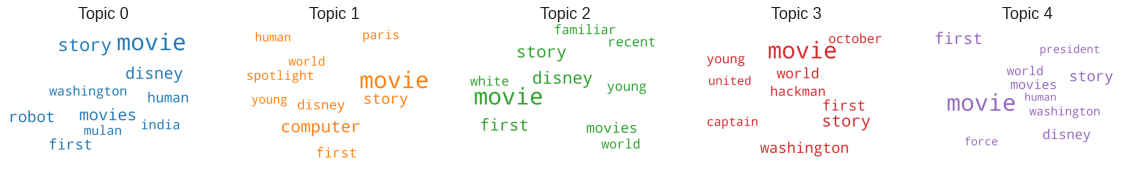

In [175]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stopwords,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = model2.show_topics(formatted=False)

fig, axes = plt.subplots(1, 5, figsize=(20,20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

In [176]:
doc2vec_model=doc2vec_model.drop('title', axis=1)

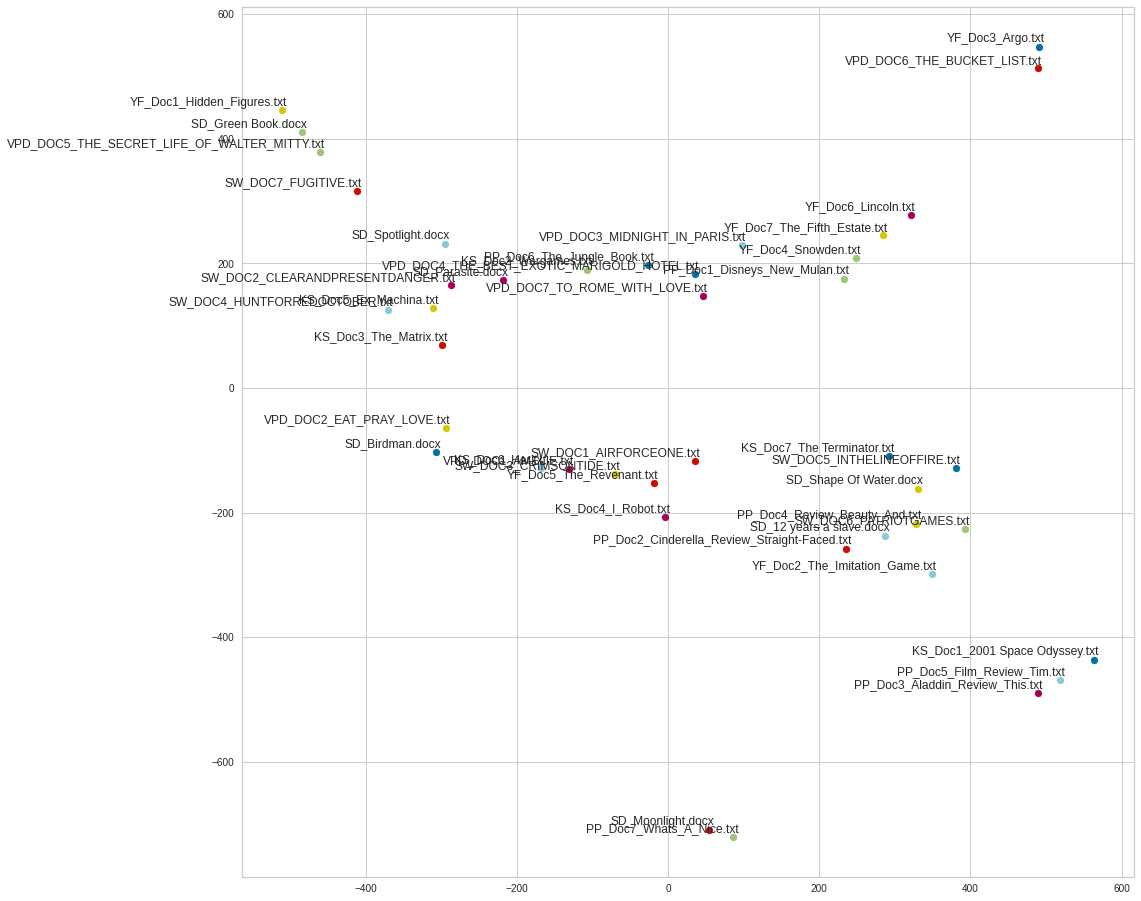

In [177]:
#plot doc2vec via TSNE
plot_doc2vec(doc2vec_model, titles)

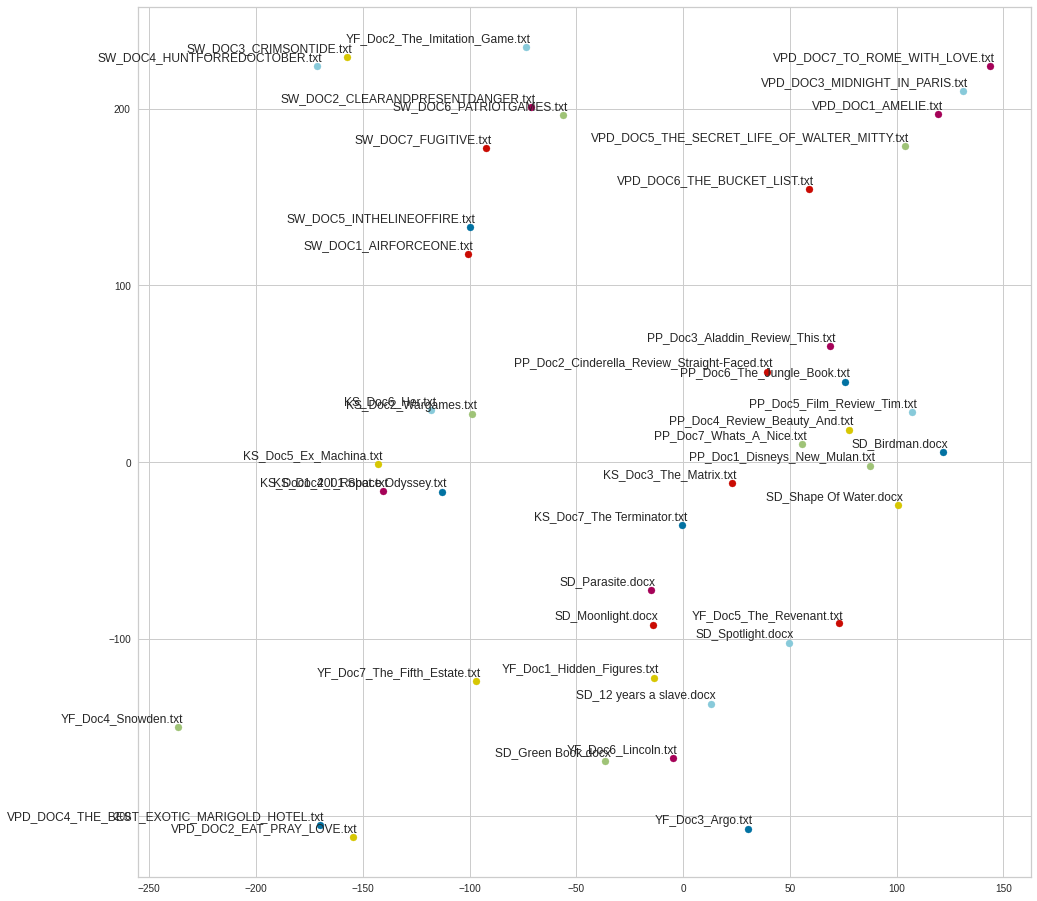

In [178]:
plot_doc2vec(tfidf_matrix, titles)